## Confidential Healthcare Modeling with ONNX on Antigranular

### Introduction

In healthcare data analysis, it's crucial to keep personal information private. We face the challenge of learning from this data while ensuring that personal details are kept confidential. This notebook demonstrates a clever way to achieve this. We'll show how ONNX (Open Neural Network Exchange) models can be used within the Antigranular environment, a tool that allows us to handle and analyse healthcare data without revealing any private information. By using ONNX models in Antigranular, we provide a secure method for conducting healthcare analyses, maintaining strict confidentiality of personal details while still gaining valuable insights from the data.

### Setting Up the Environment

Before we start, we need to set up our working environment. This includes installing the Antigranular package. Antigranular helps us perform complex data operations without compromising the confidentiality of the data.

In [ ]:
!pip install antigranular

🔐 **Getting Started with Antigranular**: To dive into our analysis, you'll first need to connect to Antigranular. Simply replace `<client_id>` and `<client_secret>` in the code with your unique credentials, which you can obtain from [antigranular.com](https://antigranular.com).

In [3]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "The Health and Census Data")

Dataset "The Health and Census Data" loaded to the kernel as the_health_and_census_data
Key Name                       Value Type     
---------------------------------------------
census                         PrivateDataFrame
health                         PrivateDataFrame

Connected to Antigranular server session id: f1f42264-a33f-4d01-b16a-e8b870bbb070, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


### Setup and Preparation

1. **Installing Required Libraries**
   - We start by installing necessary libraries `onnx`, `onnxruntime`, and `skl2onnx`. These installations is for model demonstration.

In [ ]:
!pip install onnx onnxruntime skl2onnx


2. **Importing Libraries**
   - Next, we import essential Python libraries such as `pandas` for data manipulation, `numpy` for numerical operations, and several modules from `sklearn` for model building and evaluation. For working with ONNX models, we include `onnx`, `onnxruntime`, and components from `skl2onnx`.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import onnx
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


### Crafting Synthetic Data
In this part, we create synthetic data, tailored to our analysis needs. This is crucial for two reasons: firstly, it allows us to test our methods without using real patient data, hence protecting privacy. Secondly, it provides a scalable way to simulate various scenarios. The `generate_synthetic_data` function is designed to create data that mirrors the characteristics of our actual dataset, ensuring the reliability of our analyses.

In [6]:
# Function to generate synthetic healthcare data
def generate_synthetic_data(num_samples=1000):
    np.random.seed(0)
    ages = np.random.randint(20, 80, num_samples)
    blood_pressures = np.random.normal(120, 20, num_samples).astype(int)
    cholesterols = np.random.normal(200, 50, num_samples).astype(int)

    diagnosis = []
    for i in range(num_samples):
        age_factor = (ages[i] - 20) / 60
        bp_factor = (blood_pressures[i] - 60) / 120
        chol_factor = (cholesterols[i] - 100) / 200
        score = 0.3 * age_factor + 0.4 * bp_factor + 0.3 * chol_factor + np.random.rand() * 0.1
        diagnosis.append(1 if score > 0.5 else 0)

    return pd.DataFrame({
        "PatientID": range(1, num_samples + 1),
        "Age": ages,
        "BloodPressure": blood_pressures,
        "Cholesterol": cholesterols,
        "Diagnosis": diagnosis
    })

### Dividing Data for Analysis
This section focuses on dividing our dataset into features (X) and the target (y). The features include 'Age', 'Blood Pressure', and 'Cholesterol' – these are crucial factors in healthcare analysis. The target, 'Diagnosis', is what we're trying to predict. Separating the dataset into features and target is a standard practice in machine learning. It prepares us to train models that can identify patterns in the features to predict the diagnosis accurately.

In [7]:
# Generate the synthetic dataset
df = generate_synthetic_data()

# Splitting the data into features and target
X = df[["Age", "BloodPressure", "Cholesterol"]]
y = df["Diagnosis"]


### Preparing Training and Testing Sets
Now, we split our data into training and testing sets. This is done using the `train_test_split` function. We allocate 80% of the data for training (`X_train`, `y_train`) and the remaining 20% for testing (`X_test`, `y_test`). The training set is used to teach our model, while the testing set is reserved for evaluating its performance.


In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Importing Data to Antigranular
In this part, we use the private_import method to securely transfer our synthetic dataset into Antigranular. The dataset is imported under the name 'df'. This step ensures that our data is safely integrated into the Antigranular environment.

In [9]:
# import synthetic dataset to ag as private dataset
session.private_import(data=df, name='df')

dataframe cached to server, loading to kernel...
Dataframe loaded successfully to the kernel



### Analyzing Data with Differential Privacy
In this segment, we utilize the capabilities of Antigranular to analyze the data using differential privacy methods. This approach ensures that we can derive meaningful insights from the data without compromising individual privacy.

In [10]:
%%ag
from op_pandas import PrivateDataFrame
pdf = PrivateDataFrame(df, categorical_metadata={'Diagnosis':[0, 1]})

### Analyzing Data Privately
Next, we perform a private analysis of our data. We calculate the mean values of different variables grouped by the 'Diagnosis' column. This is done using differential privacy techniques to ensure that the results don't compromise individual data privacy.

In [11]:
%%ag
mean_values_by_diagnosis = pdf.groupby('Diagnosis').mean(eps=.1)

### Exporting Analysis Results
After performing the analysis within the Antigranular environment, we export the results back to our local environment. This allows us to view and further analyze the results while ensuring that the data remains private and secure.

In [12]:
%%ag
export(mean_values_by_diagnosis, 'mean_values_by_diagnosis')

Setting up exported variable in local environment: mean_values_by_diagnosis


In [13]:
mean_values_by_diagnosis

,PatientID,Age,BloodPressure,Cholesterol
0,455.439458,35.083369,109.46373,123.960143
1,522.707288,57.568955,115.42898,211.857467


### Visualizing Data Insights
After importing the necessary libraries for visualization (matplotlib and seaborn), the notebook presents a bar chart that displays the mean blood pressure and cholesterol values, categorized by diagnosis status (0 for Negative, 1 for Positive). This visualization provides the following insights:

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

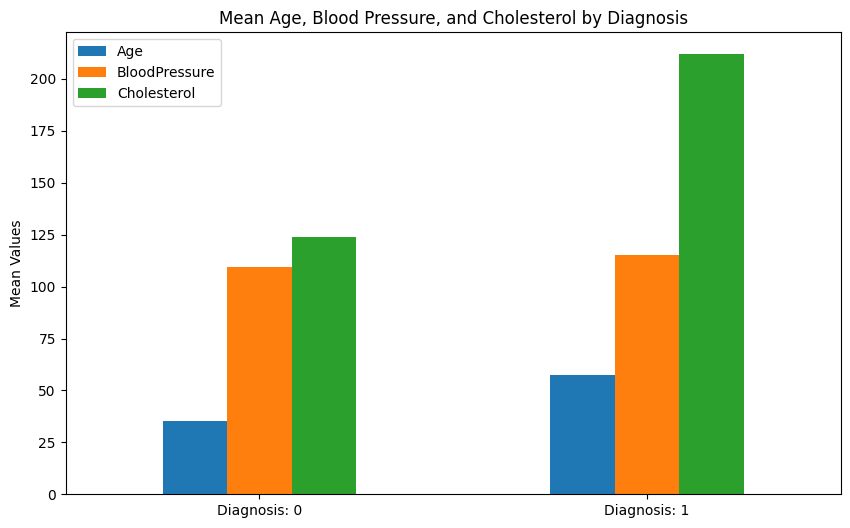

In [15]:
# Plotting the mean values by Diagnosis
mean_values_by_diagnosis[['Age', 'BloodPressure', 'Cholesterol']].plot(kind='bar', figsize=(10, 6))
plt.title('Mean Age, Blood Pressure, and Cholesterol by Diagnosis')
plt.ylabel('Mean Values')
plt.xticks(ticks=[0, 1], labels=['Diagnosis: 0', 'Diagnosis: 1'], rotation=0)
plt.show()

### Observations
- **Age**: Patients with a diagnosis of 1 (positive) have a significantly higher average age (about 57 years) compared to those with a diagnosis of 0 (about 37 years).
- **Blood Pressure**: Similarly, the average blood pressure is higher in patients with a positive diagnosis (approximately 115) compared to those without (approximately 109).
- **Cholesterol**: The trend continues with cholesterol, where patients with a positive diagnosis have a higher average cholesterol level (about 211) than those without (about 123).

These visualizations clearly illustrate the distinctions in these health metrics between the two groups.

In [16]:
%%ag
mean_bp_cholesterol_by_diagnosis = pdf.groupby('Diagnosis').mean(eps=.1)[['BloodPressure', 'Cholesterol']]

In [19]:
%%ag
export(mean_bp_cholesterol_by_diagnosis, 'mean_bp_cholesterol_by_diagnosis')

Setting up exported variable in local environment: mean_bp_cholesterol_by_diagnosis


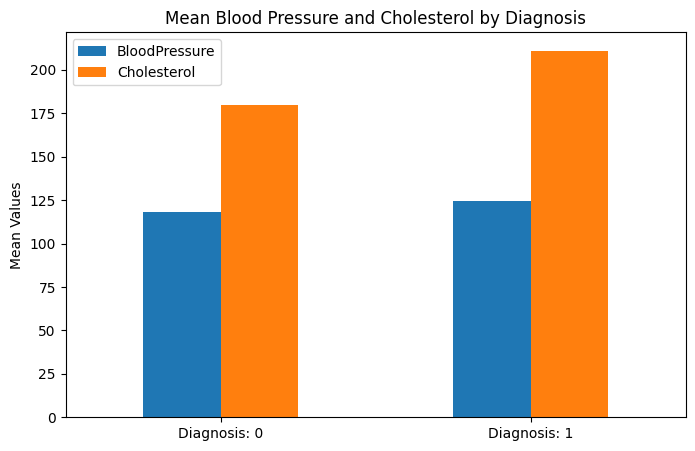

In [20]:
mean_bp_cholesterol_by_diagnosis.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Blood Pressure and Cholesterol by Diagnosis')
plt.ylabel('Mean Values')
plt.xticks(ticks=[0, 1], labels=['Diagnosis: 0', 'Diagnosis: 1'], rotation=0)
plt.show()

### Insights
The bar chart above displays the mean blood pressure and cholesterol values, separated by diagnosis status (0 or 1):

- **Diagnosis 0 (Negative)**: Shows lower average blood pressure and cholesterol levels.
- **Diagnosis 1 (Positive)**: Associated with higher average blood pressure and cholesterol levels.

This visualization effectively highlights the differences in blood pressure and cholesterol based on the diagnosis status.

### Training the Machine Learning Model
In this phase, we initiate the training of our machine learning model. We've chosen a `RandomForestClassifier` for its effectiveness in handling diverse datasets. By invoking the `fit` method, we're essentially 'teaching' the model using our training data (`X_train` and `y_train`). The model learns to correlate the features (age, blood pressure, cholesterol) with the target (diagnosis). Think of it as a student in a classroom, absorbing knowledge (training data) and learning to make informed predictions.


In [21]:
# Training the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Converting the Model to ONNX Format
After training the RandomForestClassifier, we convert it into ONNX (Open Neural Network Exchange) format. This step is crucial for deploying the model in different environments while maintaining consistency in predictions.

In [22]:
# Converting the sklearn model to ONNX format
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model to a file
onnx_model_path = "healthcare_model.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

#### Importing the ONNX Model to Antigranular
Next, we import the ONNX model into the Antigranular environment. This allows us to leverage the secure and private computation capabilities of Antigranular while utilizing our newly trained model.

In [23]:
session.private_import(path=onnx_model_path, name="onnx_model")

model cached to server, loading to kernel...
Model loaded successfully to the kernel



### Importing Test Data to Antigranular
The notebook progresses by importing the test data (X_test and y_test) into Antigranular. This step is vital for subsequent predictions with the ONNX model.

In [24]:
session.private_import(data=X_test, name="X_test")

dataframe cached to server, loading to kernel...
Dataframe loaded successfully to the kernel



### Converting Test Labels to DataFrame
Before importing the test labels (y_test) into Antigranular, we need to convert them from a Pandas Series to a DataFrame.

In [25]:
session.private_import(data=pd.DataFrame(y_test.values), name="y_test_df")

dataframe cached to server, loading to kernel...
Dataframe loaded successfully to the kernel



### Making Predictions with the ONNX Model
A custom function, make_predictions, is used within Antigranular to employ the ONNX model for prediction. This function processes the test data and utilizes the model for inference.

The model's accuracy is calculated by comparing the predictions against the actual test values. This provides an objective assessment of the model's performance.

In [26]:
%%ag
import onnxruntime as ort
import numpy as np
import pandas as pd
# Function to make predictions using ONNX model
def make_predictions(data, model):
    sess = ort.InferenceSession(model.SerializeToString())

    if isinstance(data, pd.DataFrame):
        data = data.values
    elif isinstance(data, list):
        data = np.array(data)

    if data.ndim == 1:
        data = data.reshape(1, -1)

    data = data.astype(np.float32)
    onnx_inputs = {sess.get_inputs()[0].name: data}
    onnx_output = sess.run(None, onnx_inputs)
    return onnx_output[0]

# Making predictions on the test data
onnx_predictions = make_predictions(X_test, onnx_model)

def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

# Evaluating the model
accuracy = accuracy_score(y_test_df.sort_index()[0], onnx_predictions.round())

# Output the model accuracy
ag_print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.895



### Terminating the Antigranular Session
The session in Antigranular is then properly terminated, concluding the notebook and freeing up resources.

In [27]:
session.terminate_session()

{'status': 'ok'}